In [2]:
import pandas as pd

df = pd.read_csv('/content/sample_data/milk_production.csv')
print(df.head())
print(df.tail())


     Month  Production
0  1962-01         589
1  1962-02         561
2  1962-03         640
3  1962-04         656
4  1962-05         727
       Month  Production
163  1975-08         858
164  1975-09         817
165  1975-10         827
166  1975-11         797
167  1975-12         843


In [3]:
import numpy as np

values = df['Production'].values

# Normalize data (important for LSTM)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values.reshape(-1,1))

# Function to create sequences and labels
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
X, y = create_sequences(values_scaled, SEQ_LENGTH)

print(X.shape, y.shape)  # (samples, timesteps, features)

(138, 30, 1) (138, 1)


In [4]:
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(units=200, dropout=0.8, learning_rate=0.1):
    model = models.Sequential()
    model.add(layers.LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))
    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mse', 'mae']
    )
    return model


In [6]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150]
}

for params in ParameterGrid(param_grid):
    model = build_model(units=128, dropout=0.2, learning_rate=0.01)
    print(f"Training with: batch_size={params['batch_size']}, epochs={params['epochs']}")

    history = model.fit(
        X_train, y_train,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_data=(X_val, y_val),
        verbose=0
    )
    # Log or compare val_loss or val_accuracy here


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training with: batch_size=16, epochs=50
Training with: batch_size=16, epochs=100
Training with: batch_size=16, epochs=150
Training with: batch_size=32, epochs=50
Training with: batch_size=32, epochs=100
Training with: batch_size=32, epochs=150
Training with: batch_size=64, epochs=50
Training with: batch_size=64, epochs=100
Training with: batch_size=64, epochs=150


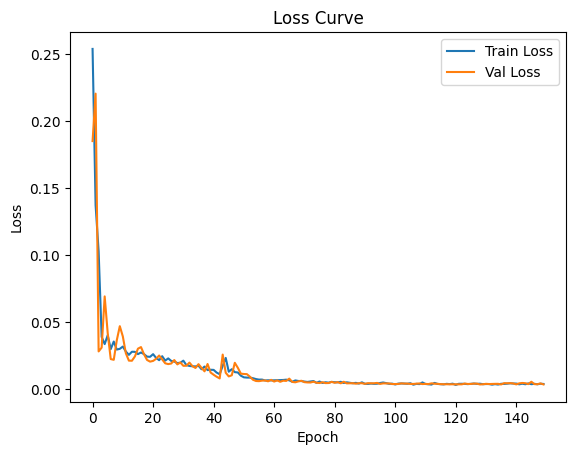

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
MSE: 579.1097
RMSE: 24.0647


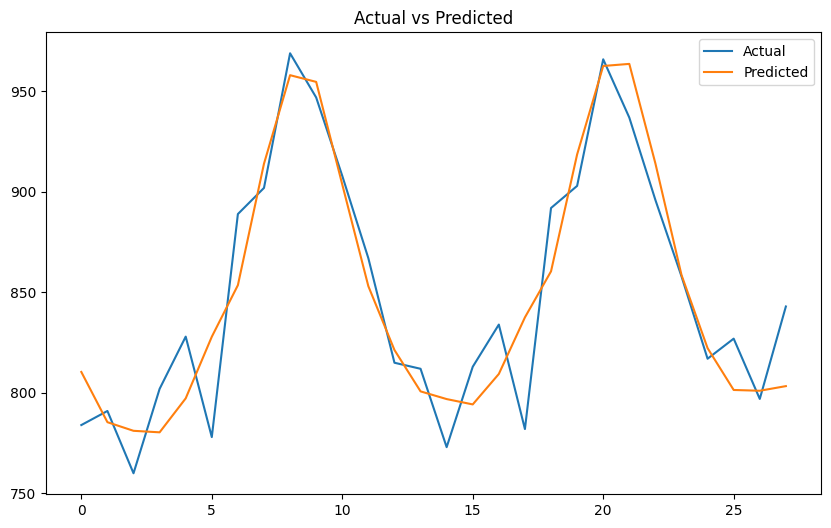

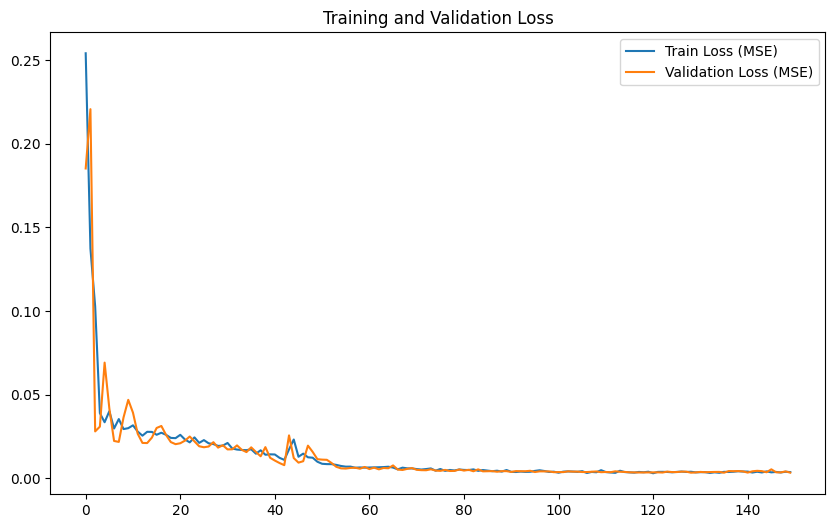

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Predict on validation data
y_pred = model.predict(X_val)

# Inverse transform to get original scale
y_val_orig = scaler.inverse_transform(y_val)
y_pred_orig = scaler.inverse_transform(y_pred)

# Calculate metrics
mse = mean_squared_error(y_val_orig, y_pred_orig)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(y_val_orig, label='Actual')
plt.plot(y_pred_orig, label='Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# **Second Code**

In [51]:
# Cell 1: Imports & Environment Check
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [33]:
# Cell 2: Load CSV & Inspect
df = pd.read_csv('/content/sample_data/milk_production.csv')
print(df.head())
print(df.tail())
print("\nColumns:", df.columns.tolist())

     Month  Production
0  1962-01         589
1  1962-02         561
2  1962-03         640
3  1962-04         656
4  1962-05         727
       Month  Production
163  1975-08         858
164  1975-09         817
165  1975-10         827
166  1975-11         797
167  1975-12         843

Columns: ['Month', 'Production']


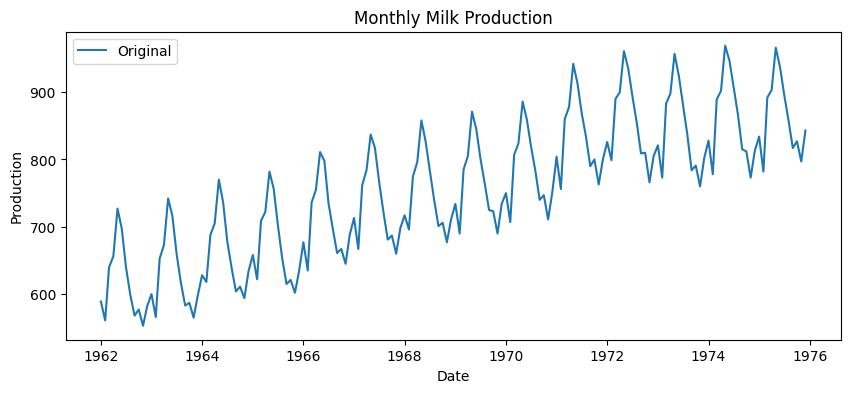

In [34]:
# Cell 3: Parse Dates & Set Index
# Adjust column names based on your CSV inspection above
df['Month']       = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df = df.asfreq('MS')             # ensure a regular monthly frequency
df.columns = ['MilkProduction']  # rename for simplicity

plt.figure(figsize=(10,4))
plt.plot(df['MilkProduction'], label='Original')
plt.title('Monthly Milk Production')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

In [35]:
# Cell 4: Feature Engineering & Scaling
# Capture seasonality with sine/cosine of month
df['month']      = df.index.month
df['sin_month']  = np.sin(2 * np.pi * df['month']/12)
df['cos_month']  = np.cos(2 * np.pi * df['month']/12)

features = ['MilkProduction', 'sin_month', 'cos_month']
scaler   = MinMaxScaler()
data     = scaler.fit_transform(df[features])

In [36]:
# Cell 5: Sequence Creation
def create_sequences(arr, n_steps):
    X, y = [], []
    for i in range(len(arr) - n_steps):
        X.append(arr[i:i+n_steps])
        y.append(arr[i+n_steps, 0])
    return np.array(X), np.array(y)

n_steps = 12
X, y    = create_sequences(data, n_steps)
print("X shape:", X.shape, "| y shape:", y.shape)

X shape: (156, 12, 3) | y shape: (156,)


In [37]:
# Cell 6: Train–Validation Split
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)

Train: (124, 12, 3) (124,)
Val:   (32, 12, 3) (32,)


In [38]:
# Cell 7: Build CNN–BiLSTM Hybrid Model
n_features = X.shape[2]

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu',
           input_shape=(n_steps, n_features)),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(128, dropout=0.2,
                       recurrent_dropout=0.1)),
    Dense(1)
])

model.compile(optimizer=Adam(1e-3), loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,529 (775.50 KB)

 Trainable params: 198,529 (775.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0042 - val_loss: 0.0035 - learning_rate: 9.7656e-07
Epoch 2/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0037 - val_loss: 0.0035 - learning_rate: 9.7656e-07
Epoch 3/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0040 - val_loss: 0.0035 - learning_rate: 9.7656e-07
Epoch 4/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0038 - val_loss: 0.0035 - learning_rate: 9.7656e-07
Epoch 5/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0043 - val_loss: 0.0035 - learning_rate: 9.7656e-07
Epoch 6/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0037 - val_loss: 0.0035 - learning_rate: 9.7656e-07
Epoch 7/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0037 - val_loss: 0.0035 - learning_rate: 4.8828e-07
Epoch 8/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0036 - val_loss: 0.0035 - learning_rate: 4.8828e-07
Epoch 9/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0034 - val_loss: 0.0035 - learning_rate: 4.8

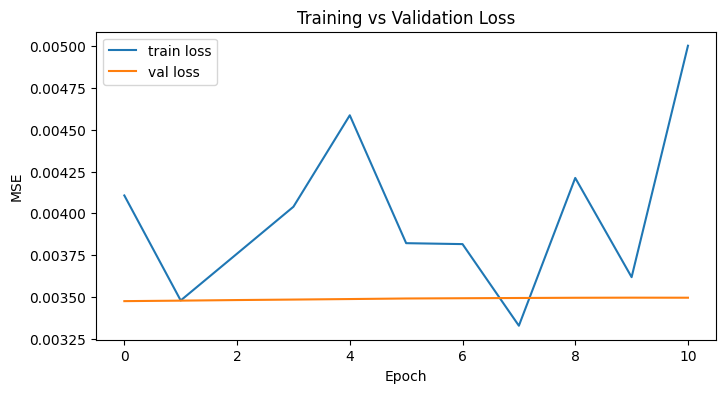

In [48]:
# Cell 8: Train with Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

history = model.fit(
    X_train, y_train,
    epochs=400,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [49]:
# Cell 9: Invert Scaling & Compute Metrics
# Predict on validation set
y_pred_scaled = model.predict(X_val)

# Build dummy arrays to invert only the first column
inv_dummy = np.zeros((len(y_pred_scaled), n_features))
inv_dummy[:,0] = y_pred_scaled[:,0]
y_pred = scaler.inverse_transform(inv_dummy)[:,0]

true_dummy = np.zeros((len(y_val), n_features))
true_dummy[:,0] = y_val
y_true = scaler.inverse_transform(true_dummy)[:,0]

# Calculate errors
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f"MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
MSE: 601.368 | RMSE: 24.523 | MAE: 19.443


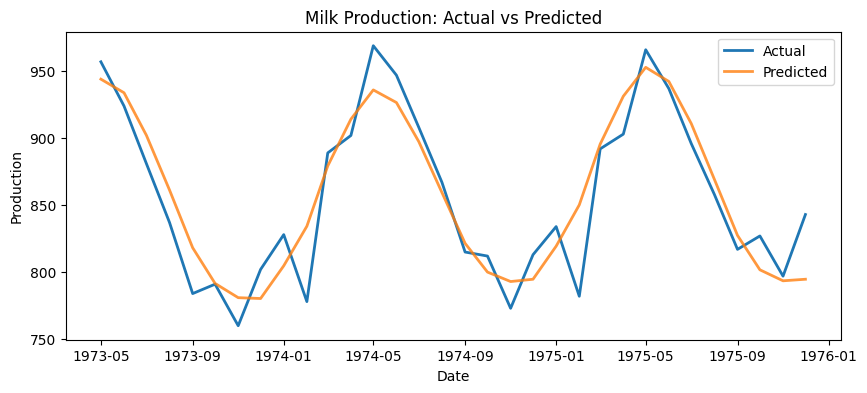

In [50]:
# Cell 10: Plot Actual vs Predicted
dates = df.index[-len(y_true):]

plt.figure(figsize=(10,4))
plt.plot(dates, y_true, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linewidth=2, alpha=0.8)
plt.title('Milk Production: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

In [53]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


# **Third Code**

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D,
    Bidirectional, LSTM, Dense,
    Dropout, Activation, Flatten,
    Permute, Multiply, RepeatVector,
    Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import keras_tuner as kt

In [55]:
# Load & preprocess
df = pd.read_csv('/content/sample_data/milk_production.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df = df.asfreq('MS')
df.columns = ['Milk']

# add seasonality
df['sin_m'] = np.sin(2*np.pi*df.index.month/12)
df['cos_m'] = np.cos(2*np.pi*df.index.month/12)

# scale
scaler = MinMaxScaler()
arr    = scaler.fit_transform(df[['Milk','sin_m','cos_m']])

# sequence builder
def make_seqs(data, n_steps=12):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps,0])
    return np.array(X), np.array(y)

n_steps = 12
X, y    = make_seqs(arr, n_steps)

# train/validation split
split = int(0.8 * len(X))
X_tr, X_va = X[:split], X[split:]
y_tr, y_va = y[:split], y[split:]
n_feats = X.shape[2]

In [56]:
def build_tuned_model(hp):
    inp = Input(shape=(n_steps, n_feats))

    # Tune number of Conv1D filters and kernel size
    filters    = hp.Choice('conv_filters', [32, 64, 128])
    kernel     = hp.Choice('kernel_size', [3, 5])
    x = Conv1D(filters, kernel, activation='relu')(inp)
    x = MaxPooling1D(2)(x)

    # Tune LSTM units
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=64)
    x = Bidirectional(
        LSTM(lstm_units, return_sequences=True)
    )(x)

    # Attention block (static)
    e     = Dense(1, activation='tanh')(x)
    e     = Flatten()(e)
    alpha = Activation('softmax')(e)
    alpha = RepeatVector(x.shape[-1])(alpha)
    alpha = Permute([2, 1])(alpha)
    x     = Multiply()([x, alpha])
    x     = Lambda(lambda t: tf.reduce_sum(t, axis=1))(x)

    # Tune dropout rate
    dr   = hp.Float('dropout', 0.1, 0.5, step=0.1)
    x    = Dropout(dr)(x)
    out  = Dense(1)(x)

    model = Model(inp, out)

    # Tune learning rate
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=Adam(lr),
        loss='mse'
    )
    return model

In [57]:
tuner = kt.Hyperband(
    build_tuned_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='milk_tuner',
    project_name='cnn_bilstm_attention'
)

# Early stopping to speed up bad trials
stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    X_tr, y_tr,
    epochs=50,
    validation_data=(X_va, y_va),
    callbacks=[stop_early],
    batch_size=16,
    verbose=2
)


# Summarize results
tuner.results_summary()

Trial 90 Complete [00h 00m 25s]
val_loss: 0.004255363252013922

Best val_loss So Far: 0.002059764927253127
Total elapsed time: 00h 17m 19s
Results summary
Results in milk_tuner/cnn_bilstm_attention
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0083 summary
Hyperparameters:
conv_filters: 128
kernel_size: 5
lstm_units: 192
dropout: 0.2
learning_rate: 0.0011331682914451785
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0079
Score: 0.002059764927253127

Trial 0084 summary
Hyperparameters:
conv_filters: 64
kernel_size: 3
lstm_units: 64
dropout: 0.1
learning_rate: 0.004389542789450444
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0075
Score: 0.0022573163732886314

Trial 0051 summary
Hyperparameters:
conv_filters: 32
kernel_size: 5
lstm_units: 192
dropout: 0.30000000000000004
learning_rate: 0.0024612244291025358
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round:

In [58]:
# Get the top model
best_model = tuner.get_best_models(num_models=1)[0]

# Predict & invert scale
y_pred_s = best_model.predict(X_va)
dummy    = np.zeros((len(y_pred_s), n_feats))
dummy[:,0] = y_pred_s[:,0]
y_pred = scaler.inverse_transform(dummy)[:,0]

true_dummy = np.zeros((len(y_va), n_feats))
true_dummy[:,0] = y_va
y_true = scaler.inverse_transform(true_dummy)[:,0]

# Compute metrics
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"Best model RMSE: {rmse:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Best model RMSE: 18.88


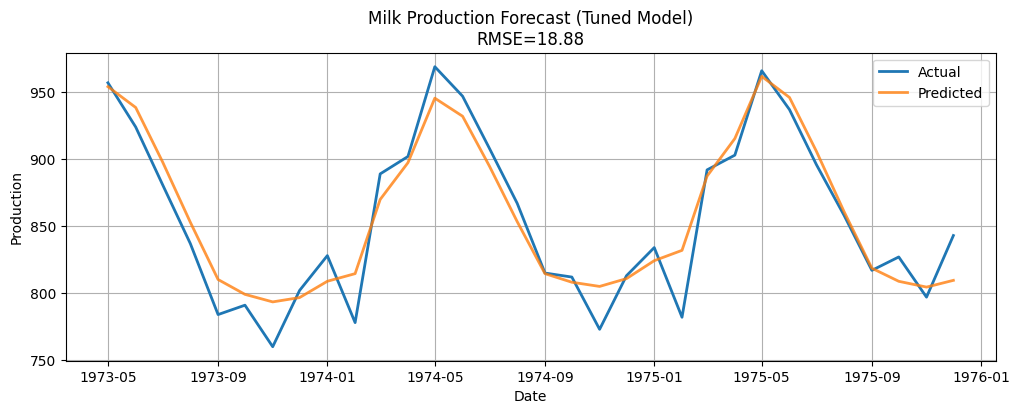

In [59]:
dates = df.index[-len(y_true):]

plt.figure(figsize=(12,4))
plt.plot(dates, y_true, label='Actual',   linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linewidth=2, alpha=0.8)
plt.title(f'Milk Production Forecast (Tuned Model)\nRMSE={rmse:.2f}')
plt.xlabel('Date'); plt.ylabel('Production')
plt.legend(); plt.grid(True); plt.show()